In [1]:
# core
import sys
import time

# custom
sys.path.append('../code/poloniex')
import polo_eda as pe
import calc_TA_sigs as cts

# installed
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler as SS

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pe.read_trade_hist('BTC_DASH')

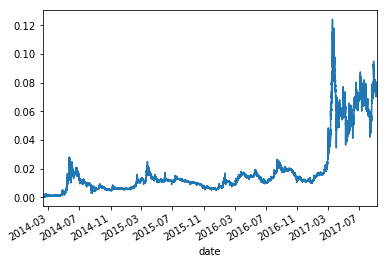

In [3]:
f = df.rate.plot()

In [4]:
# resamples to the minute
rs = df['rate'].resample('T').ohlc().interpolate()
rs_vol = pd.DataFrame(df['amount'].resample('T').sum().interpolate())
rs_vol.rename(columns={'amount':'volume'}, inplace=True)
rs_full = rs.merge(rs_vol, left_index=True, right_index=True)

In [5]:
rs_full.head()

,open,high,low,close,volume
date,,,,,
2014-02-07 20:41:00,0.000080,0.000080,0.000080,0.000080,19.081615
2014-02-07 20:42:00,0.000101,0.000101,0.000101,0.000101,24.861499
2014-02-07 20:43:00,0.000121,0.000121,0.000121,0.000121,30.641384
2014-02-07 20:44:00,0.000142,0.000142,0.000142,0.000142,36.421269
2014-02-07 20:45:00,0.000163,0.000163,0.000163,0.000163,42.201153


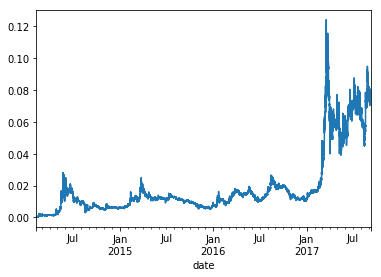

In [6]:
f = rs_full.close.plot()

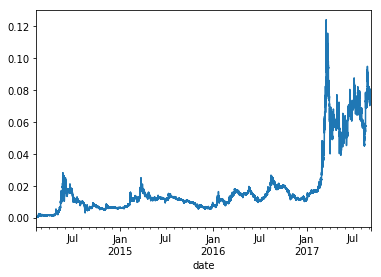

In [7]:
f = rs_full.iloc[2000:].close.plot()

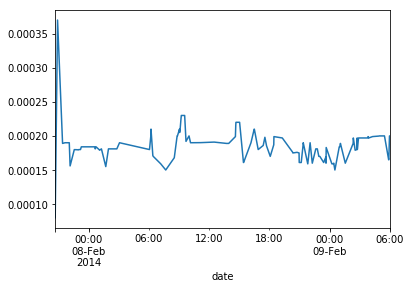

In [8]:
f = rs_full.iloc[:2000].close.plot()

In [9]:
def transform_data(df, mva=30):
    """
    This is for scaling the original data for use in machine learning.

    Takes a numpy array as input, divides by a moving average with period mva (integer),
    and returns the scaled data as well as the scaler
    and moving average (needed for returning the data to its original form).

    :param df:
    :param mva: moving average period

    With minutely OHLCV bars, this takes a 30-min MVA by default.
    """
    scalers = {}
    new_df_dict = {}
    for c in df.columns:
        scalers[c] = SS()
        rolling_mean = df[c].rolling(window=mva).mean().bfill()
        mva_scaled = df[c] / rolling_mean
        # use sklearn scaler to fit and transform scaled values
        scaled = scalers[c].fit_transform(mva_scaled.values.reshape(-1, 1))
        # need to just grab values from the column for the dataframe to work
        new_df_dict[c] = scaled[:, 0]

    new_df = pd.DataFrame(new_df_dict)

    return new_df, scalers

In [10]:
rs_full_scaled, scalers = transform_data(rs_full)

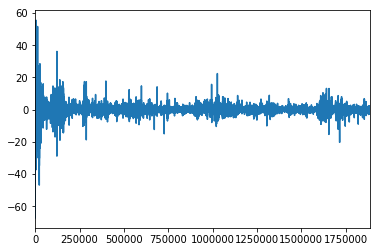

In [11]:
f = rs_full_scaled.close.plot()

In [12]:
def reform_data(df, scaled_df, scalers, mva=30):
    """
    Re-constructs original data from the transformed data.
    Requires the dataset number or to specify
    that its the original data
    """
    unsc_dict = {}
    for c in scaled_df.columns:
        unscaled = scalers[c].inverse_transform(scaled_df[c])
        rolling_mean = df[c].rolling(window=mva).mean().bfill()
        unsc = unscaled * rolling_mean
        unsc_dict[c] = unsc
    
    unsc_df = pd.DataFrame(unsc_dict)
    
    return unsc_df

In [13]:
def rescale_data(scaled_df, scalers):
    unsc_dict = {}
    for c in scaled_df.columns:
        unscaled = scalers[c].inverse_transform(scaled_df[c])
        unsc_dict[c] = unscaled
    
    unsc_df = pd.DataFrame(unsc_dict)
    
    return unsc_df

In [14]:
def rescale_prediction(prediction, scalers):
    """
    :param prediction: the closing price prediction, which has been scaled
    :param scalers: dict of standardscalers used to scale known data
    """
    return scalers['close'].inverse_transform(prediction.reshape(-1, 1))[0][0]

In [15]:
def unscale_prediction(df, prediction, mva=30):
    """
    :param df: a pandas dataframe of the known data.  This should be the natural data,
                not scaled or normalized
    :param prediction: rescaled  
    """
    return df.iloc[-mva + 1:].close.sum() / (mva - prediction)

In [16]:
unsc_df = reform_data(rs_full, rs_full_scaled, scalers)

In [17]:
np.allclose(unsc_df.close, rs_full.close)

True

# now prototype unscaling future predictions without a known moving average

In [18]:
known_df = rs_full.iloc[:-2000]
unk_df = rs_full.iloc[-2000:]

In [19]:
known_scaled, scalers = transform_data(known_df)

In [20]:
known_resc = reform_data(known_df, known_scaled, scalers)

In [21]:
np.allclose(known_resc.close, known_df.close)

True

In [22]:
rs_full_scaled, _ = transform_data(rs_full)

In [23]:
unk_unsc = rescale_data(rs_full_scaled[-2000:], scalers)

# see if we can get the first point right without using the actual MVA

In [24]:
unk_df.iloc[0].close

0.076498269999999993

In [25]:
rs_full.iloc[-2000].close

0.076498269999999993

In [26]:
rs_full_scaled.iloc[-2000].close

0.10332131896874668

In [27]:
unk_unsc.iloc[0].close

1.0011547368967713

In [28]:
known_df.iloc[-29:].close.sum() / (30 - unk_unsc.iloc[0].close)

0.076410084777385437

In [29]:
unk_df.iloc[0].close

0.076498269999999993

In [30]:
np.allclose(known_df.iloc[-29:].close.sum() / (30 - unk_unsc.iloc[0].close), unk_df.iloc[0].close)

False

In [31]:
known_df.iloc[-29:].close.sum() / (30 - unk_unsc.iloc[0].close) - unk_df.iloc[0].close

-8.8185222614556302e-05

In [32]:
(known_df.iloc[-29:].close.sum() / (30 - unk_unsc.iloc[0].close) - unk_df.iloc[0].close) / unk_df.iloc[0].close

-0.0011527740773033992

# so it's off by 0.1%...meh

In [33]:
known_df.iloc[-29:].close.sum()

2.2158042249999998

In [34]:
(30 * (1-unk_unsc.iloc[0].close))

-0.034642106903137737

In [35]:
43.1867/0.073

591.5986301369863

In [36]:
rs_full.iloc[-2029:-1999].close.sum()/30

0.07641008316666667

In [37]:
rs_full.iloc[-2029:-1999].close.sum()/30 * unk_unsc.iloc[0].close

0.076498316708984576

In [38]:
unk_df.iloc[0].close

0.076498269999999993

In [39]:
np.allclose(rs_full.iloc[-2029:-1999].close.sum()/30 * unk_unsc.iloc[0].close, unk_df.iloc[0].close)

True

In [40]:
rs_full.iloc[-2029:-1999].close.sum()/30 * unk_unsc.iloc[0].close - unk_df.iloc[0].close

4.6708984582921609e-08

# test the new functions

In [41]:
prediction = rescale_prediction(rs_full_scaled.iloc[-2000].close, scalers)

In [42]:
prediction

1.0011547368967713

In [43]:
unsc_pred = unscale_prediction(known_df, prediction)
unsc_pred

0.076410084777385437

In [44]:
actual = rs_full.iloc[-2000].close
actual

0.076498269999999993

In [45]:
# so 0.16% off here
(unsc_pred - actual) / unsc_pred * 100

-0.11541044990524062

# Now, just to make sure, test on the last 2000 points

In [46]:
all_u_preds = []
pct_diffs = []
# goes from -2000 to -1 in steps of 1
for i in range(-1000, 0, 1):
    known_df = rs_full.iloc[-10000:i]
    known_scaled, scalers = transform_data(known_df)
    prediction = rescale_prediction(rs_full_scaled.iloc[i].close, scalers)
    unsc_pred = unscale_prediction(known_df, prediction)
    all_u_preds.append(unsc_pred)
    pct_diffs.append((unsc_pred - rs_full.iloc[i].close) / unsc_pred * 100)

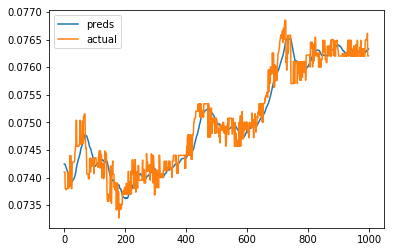

In [47]:
f = plt.plot(all_u_preds, label='preds')
f = plt.plot(rs_full.iloc[-1000:-1].close.values, label='actual')
l = plt.legend()

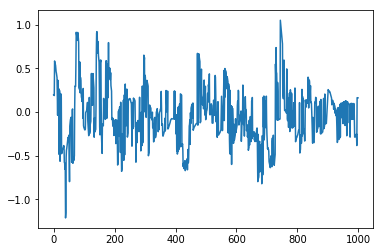

In [48]:
f = plt.plot(pct_diffs)

# looks like it's off by about +/-1% at most.  Not super great, but acceptable enough to move on